## Import

In [1]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from tqdm.auto import tqdm

## Fixed Random Seed

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

## Data Load

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


## Train Data Pre-processing

In [5]:
# 일조, 일사 열 제거
train_df = train_df.drop(['일조(hr)','일사(MJ/m2)'], axis=1)
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,986.40


In [6]:
# 결측치 확인
train_df.isna().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
전력소비량(kWh)            0
dtype: int64

In [7]:
# 강수량 결측치 0.0으로 채우기
train_df['강수량(mm)'].fillna(0.0, inplace=True)

# 풍속, 습도 결측치 평균으로 채우고 반올림하기
train_df['풍속(m/s)'].fillna(round(train_df['풍속(m/s)'].mean(),2), inplace=True)
train_df['습도(%)'].fillna(round(train_df['습도(%)'].mean(),2), inplace=True)

In [8]:
train_df['month'] = train_df['일시'].apply(lambda x : float(x[4:6]))
train_df['day'] = train_df['일시'].apply(lambda x : float(x[6:8]))
train_df['time'] = train_df['일시'].apply(lambda x : float(x[9:11]))

In [9]:
# 순서 재배치
train_df = train_df[train_df.columns[:7].to_list() + train_df.columns[8:].to_list() + train_df.columns[7:8].to_list()]
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),month,day,time,전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,0.0,0.9,42.0,6.0,1.0,0.0,1085.28
1,1_20220601 01,1,20220601 01,18.0,0.0,1.1,45.0,6.0,1.0,1.0,1047.36
2,1_20220601 02,1,20220601 02,17.7,0.0,1.5,45.0,6.0,1.0,2.0,974.88
3,1_20220601 03,1,20220601 03,16.7,0.0,1.4,48.0,6.0,1.0,3.0,953.76
4,1_20220601 04,1,20220601 04,18.4,0.0,2.8,43.0,6.0,1.0,4.0,986.40


## Hyperparameter Setting

In [10]:
# 하이퍼파라미터
input_size = 8  # feature의 개수
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 5
window_size = 24  # 예측에 사용될 시간 윈도우 크기
batch_size = 64
learning_rate = 0.001

## Dataset

In [59]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size):
        self.df = df
        self.window_size = window_size

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = torch.tensor(self.df[idx:idx+self.window_size, :], dtype=torch.float)
        if self.df.shape[1] > 1:
            y = torch.tensor(self.df[idx+self.window_size, -1], dtype=torch.float)
        else:
            y = None
        return x, y

def create_data_loader(df, window_size, batch_size):
    dataset = TimeSeriesDataset(df, window_size)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader

In [60]:
# normalization
train_data = train_df.drop(['num_date_time', '건물번호', '일시'], axis=1)

for col in train_data.columns:
    if col!='전력소비량(kWh)':
        scaler = MinMaxScaler()
        train_data[col] = scaler.fit_transform(np.array(train_data[col]).reshape(-1,1)).flatten()

train_loader = create_data_loader(train_data.values, window_size, batch_size)

## Model Define

In [61]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"current device: {device}")

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

current device: cpu


In [86]:
model

LSTM(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## Train

In [68]:
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(train_loader), np.sqrt(loss.item())))

Epoch [1/5], Step [100/3188], Loss: 964.0070
Epoch [1/5], Step [200/3188], Loss: 979.8678
Epoch [1/5], Step [300/3188], Loss: 4089.1703
Epoch [1/5], Step [400/3188], Loss: 2357.6244
Epoch [1/5], Step [500/3188], Loss: 3908.5572
Epoch [1/5], Step [600/3188], Loss: 1896.9689
Epoch [1/5], Step [700/3188], Loss: 1135.5128
Epoch [1/5], Step [800/3188], Loss: 3263.8114
Epoch [1/5], Step [900/3188], Loss: 1447.6790
Epoch [1/5], Step [1000/3188], Loss: 9914.5925
Epoch [1/5], Step [1100/3188], Loss: 2099.1452
Epoch [1/5], Step [1200/3188], Loss: 1956.5312
Epoch [1/5], Step [1300/3188], Loss: 3888.0184
Epoch [1/5], Step [1400/3188], Loss: 2461.1267
Epoch [1/5], Step [1500/3188], Loss: 1326.2360
Epoch [1/5], Step [1600/3188], Loss: 2426.2677
Epoch [1/5], Step [1700/3188], Loss: 1876.7469
Epoch [1/5], Step [1800/3188], Loss: 2038.0559
Epoch [1/5], Step [1900/3188], Loss: 3107.7669
Epoch [1/5], Step [2000/3188], Loss: 855.9625
Epoch [1/5], Step [2100/3188], Loss: 355.5226
Epoch [1/5], Step [2200/31

KeyboardInterrupt: 

In [70]:
def predict(best_model,loader,device): #transform_y
    best_model.to(device)
    best_model.eval()
    
    true_list = []
    pred_list = []
    with torch.no_grad():
        for data,label in iter(loader):
            data = data.float().to(device)

            output = best_model(data).cpu().numpy().flatten().tolist()
            label  = label.cpu().numpy().flatten().tolist()

            #if transform_y=='log':
            #    output = np.exp(output).tolist()
            #    label  = np.exp(label).tolist()
            #elif transform_y=='sqrt':
            #    output = np.square(output).tolist()
            #    label  = np.square(label).tolist()

            true_list += label
            pred_list += output

    return true_list, pred_list

In [71]:
tr_true, tr_pred = predict(model,train_loader,device)

In [72]:
len(tr_true), len(tr_pred)

(203976, 203976)

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/khj/.pyenv/versions/3.8.10/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/khj/.pyenv/versions/3.8.10/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/khj/.pyenv/versions/3.8.10/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/khj/.pyenv/versions/3.8.10/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/khj/.pyenv/versions/3.8.10/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYAN

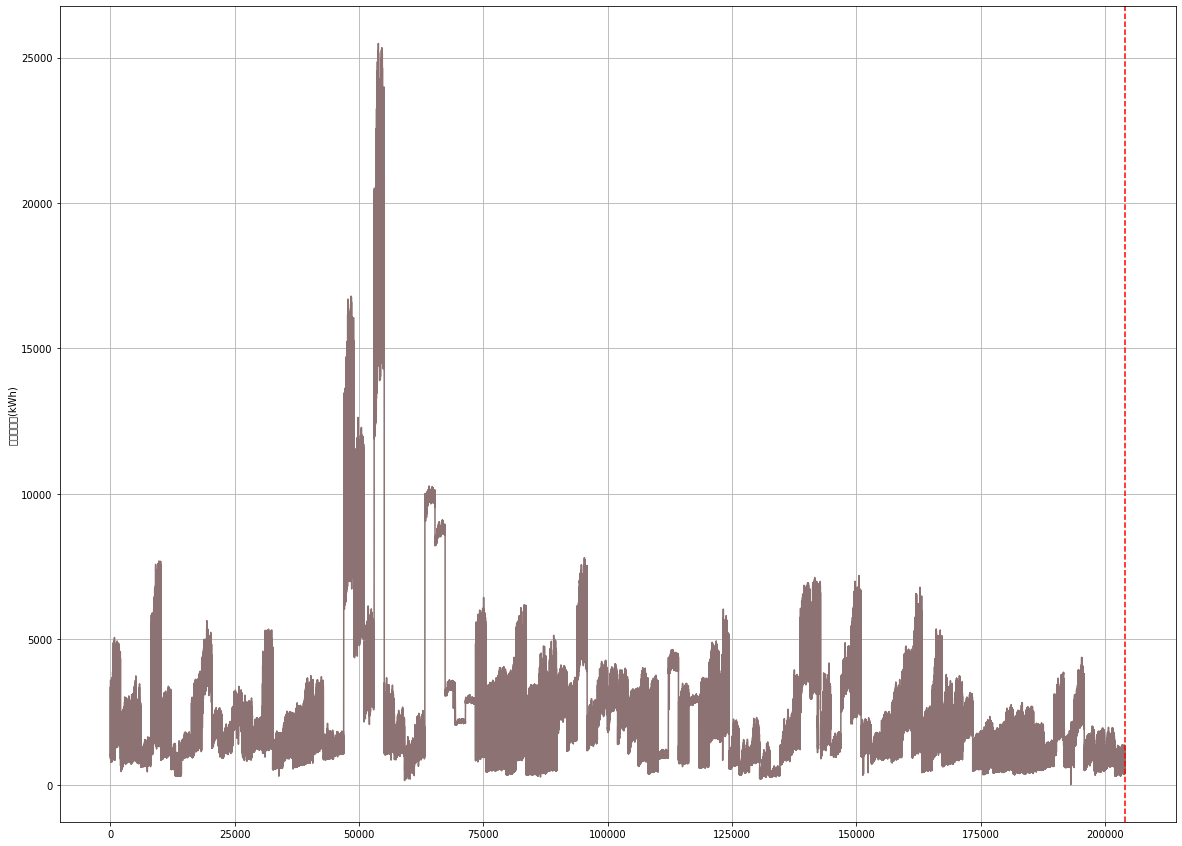

In [85]:
true = tr_true
pred = train_data['전력소비량(kWh)']

plt.figure(figsize=(20,15))
sns.lineplot(x=range(len(true)),y=true,color='gray',alpha=1)
sns.lineplot(x=range(len(pred)),y=pred,color='red',alpha=0.1)
plt.axvline(len(tr_true),color='red',linestyle='--')
plt.grid()
plt.show()

## Test Data Pre-processing

In [69]:
# 학습 데이터에서 마지막 행 가져오기
last_train_data = train_df.drop(['num_date_time', '건물번호', '일시',], axis=1).loc[204000-24:,:]

# 실수형 데이터로 변환
test_df['습도(%)'] = test_df['습도(%)'].astype('float64')

# 날짜 데이터 추가
test_df['month'] = test_df['일시'].apply(lambda x : float(x[4:6]))
test_df['day'] = test_df['일시'].apply(lambda x : float(x[6:8]))
test_df['time'] = test_df['일시'].apply(lambda x : float(x[9:11]))

# 전력소비량 열 생성
final_df = pd.concat((test_df.drop(['num_date_time', '건물번호', '일시',], axis=1), pd.DataFrame(np.zeros(test_df.shape[0]))),axis=1)
final_df = final_df.rename({0:'전력소비량(kWh)'},axis=1)

## Test Dataset

In [ ]:
test_df = pd.concat((last_train_data, final_df)).reset_index(drop=True)
test_data = scaler.transform(test_df.values) # train과 동일하게 scaling
test_data.shape

In [ ]:
# Dataset & DataLoader
test_dataset = TimeSeriesDataset(test_data, window_size)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Inference

In [ ]:
model.eval()

test_predictions = []

with torch.no_grad():
    for i in range(test_data.shape[0] - window_size):
        x = torch.Tensor(test_data[i:i+window_size,:]).to(device)
        new_x = model(x.view(1,window_size,-1))
        
        test_data[i+window_size,-1] = new_x # 입력 업데이트
        test_predictions.append(new_x.detach().cpu().numpy().item()) # 예측 결과 저장

## Submit

In [ ]:
predictions = scaler.inverse_transform(test_data)[24:,-1] # 원래 scale로 복구

In [ ]:
sample_submission['answer'] = predictions
sample_submission.head()

In [ ]:
sample_submission.to_csv('lstm_baseline_submission.csv', index=False)